# INTELIGENCIA ARTIFICIAL

## Proyecto 2: Aprendizaje no supervisado

Hecho por: Juan Sebastián Clavijo Martínez<br />
TEMA: Se usaron los datos proporcionados por el profesor para implementar los dos problemas del sistema de recomendacion y cuantización de imagenes<br />
Fecha: 20-10-2024<br />
Notas: Este trabajo no representa la calidad de lo quedo hacer, pido disculpas de antemano y acepto la nota que obtenga, en el 3er proyecto, lo haré mejor <br />
**Pontificia Universidad Javeriana**


In [84]:
# Importado de bibliotecas pertinentes

import pandas as pd  # tratamiento de datos en un dataframe
import numpy as np  # numerical python
import seaborn as sns  # biblioteca versatil para estadistica y visualizacion
import matplotlib.pyplot as plt  # biblioteca para vizualizacion de datos

# Imports necesarios para el punto 1

# Imports necesarios para el punto 2

import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

## PROBLEMA 1: SISTEMA DE RECOMENDACIÓN

### Parte 1.1 procesamiento de datos

#### parte 1.1.1 carga de datos
#### Ya que hay una gran cantidad de datos proporcionados, se procederá a presentar cada dataframe en un bloque de código separado. inmediatamente después se hará un análisis descriptivo de cada df para explotar patrones, correlaciones y distribuciones relevantes que permitan identificar características clave de los datos. A partir de esto, se consolidará la información más importante en un solo dataframe, lo que facilitará un análisis integral y facilitará la implementación del sistema de recomendación

In [85]:
# parte 1.1.1.1 carga de ratings

# Cargar el dataframe de ratings
ratings_df = pd.read_excel('data/u_data_ratings.xls', names=['User ID', 'Movie ID', 'Rating', 'Timestamp'])

# Eliminar la columna 'Timestamp' ya que no es información relevante para el proyecto en cuestión porque 
ratings_df = ratings_df.drop(columns=['Timestamp'])

# Vista previa del dataframe
ratings_df

User ID  Movie ID  Rating
0          196       242       3
1          186       302       3
2           22       377       1
3          244        51       2
4          166       346       1
...        ...       ...     ...
65530      739       187       4
65531      787       331       3
65532      683       311       3
65533      807        62       3
65534      705       684       3

[65535 rows x 3 columns]

### Estadísticas Generales del df_ratings ###

            User ID      Movie ID        Rating
count  65535.000000  65535.000000  65535.000000
mean     367.034043    426.078508      3.533883
std      222.393136    330.886130      1.130528
min        1.000000      1.000000      1.000000
25%      194.000000    174.000000      3.000000
50%      345.000000    322.000000      4.000000
75%      526.000000    634.000000      4.000000
max      921.000000   1669.000000      5.000000

### Cantidad Total de Usuarios y Películas ###
Usuarios: 916
Películas: 1626

### Distribución de Calificaciones ###
Rating
1     4147
2     7246
3    17652
4    22452
5    14038
Name: count, dtype: int64


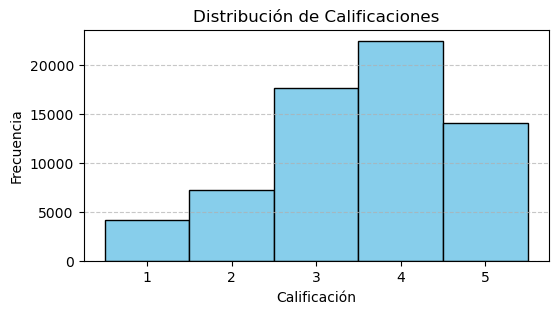


### Estadísticas de Calificaciones por Usuario ###
count    916.000000
mean      71.544760
std       79.369449
min        1.000000
25%       20.000000
50%       42.000000
75%       99.000000
max      590.000000
dtype: float64

### Estadísticas de Calificaciones por Película ###
count    1626.000000
mean       40.304428
std        52.678031
min         1.000000
25%         5.000000
50%        19.000000
75%        55.000000
max       386.000000
dtype: float64


In [86]:
# Parte 1.1.1.1.1 Análisis descriptivo general del dataframe
general_stats = ratings_df.describe()

# Cantidad total de usuarios y películas
num_users = ratings_df['User ID'].nunique()
num_movies = ratings_df['Movie ID'].nunique()

# Distribución de las calificaciones
rating_distribution = ratings_df['Rating'].value_counts().sort_index()

# Calificaciones por usuario
ratings_per_user = ratings_df.groupby('User ID').size().describe()

# Calificaciones por película
ratings_per_movie = ratings_df.groupby('Movie ID').size().describe()

# Mostrar resultados organizados
print("### Estadísticas Generales del df_ratings ###\n")
print(general_stats)

print("\n### Cantidad Total de Usuarios y Películas ###")
print(f"Usuarios: {num_users}")
print(f"Películas: {num_movies}")

print("\n### Distribución de Calificaciones ###")
print(rating_distribution)
# Graficar la distribución de calificaciones
plt.figure(figsize=(6,3))
plt.hist(ratings_df['Rating'], bins=range(1, 7), align='left', color='skyblue', edgecolor='black')
plt.title('Distribución de Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.xticks(range(1, 6))  # Ajustar los ticks del eje x para mostrar solo las calificaciones
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n### Estadísticas de Calificaciones por Usuario ###")
print(ratings_per_user)

print("\n### Estadísticas de Calificaciones por Película ###")
print(ratings_per_movie)


## Analisis de las medidas de ratings_df:

El análisis de los datos revela una distribución sesgada hacia calificaciones altas (especialmente 4 y 3), lo que podría afectar la precisión de los modelos predictivos al presentar un desbalance significativo en las etiquetas. La media de calificaciones por usuario es de aproximadamente 72, pero la alta desviación estándar indica que algunos usuarios han calificado pocas películas, mientras que otros han calificado muchas, lo que sugiere la necesidad de segmentar los usuarios para obtener un subgrupo más equilibrado. Asimismo, la media de calificaciones por película es de 40, con una amplia dispersión que implica que algunas películas son muy populares, mientras que otras tienen escasa atención.

In [87]:
# parte 1.1.1.2 carga de géneros

# Cargar el dataframe de géneros
genres_df = pd.read_excel('data/u_movies_genre.xls', header=None, names=['Genre', 'Genre ID'])


# Separar el nombre del género y el ID usando el delimitador "|"
genres_df[['Genre', 'Genre ID']] = genres_df['Genre'].str.split('|', expand=True)

# Convertir 'Genre ID' a un valor entero
genres_df['Genre ID'] = genres_df['Genre ID'].astype(int)

# Vista previa del dataframe
genres_df.head()

Genre  Genre ID
0     unknown         0
1      Action         1
2   Adventure         2
3   Animation         3
4  Children's         4

In [88]:
# Análisis descriptivo
genre_count = genres_df['Genre'].value_counts()
unique_genres = genres_df['Genre'].nunique()

# Imprimir resultados
print(f"\n### Número total de géneros únicos: {unique_genres} ###")
print(f"\n### Distribución de géneros ###\n{genre_count}")


### Número total de géneros únicos: 19 ###

### Distribución de géneros ###
Genre
unknown        1
Film-Noir      1
War            1
Thriller       1
Sci-Fi         1
Romance        1
Mystery        1
Musical        1
Horror         1
Fantasy        1
Action         1
Drama          1
Documentary    1
Crime          1
Comedy         1
Children's     1
Animation      1
Adventure      1
Western        1
Name: count, dtype: int64


> [!IMPORTANT]  
> Si tomaramos los datos del generes_df al pie de la letra, realmente no obtenemos mucho, si los combinamos con, por ejemplo, el de calificaciones y peliculas, podemos obtener nuevas perspectivas, más adelante se hace este desarrollo

In [89]:
# parte 1.1.1.3 carga de información sobre las películas (ítems)

# Cargar el dataframe de películas
movies_df = pd.read_excel('data/u_movies_items.xls', header=None)

# Separar la columna en múltiples columnas utilizando el delimitador "|"
movies_df = movies_df[0].str.split('|', expand=True)

# Nombrar columnas de interés
movies_df.columns = ['Movie ID', 'Title', 'Release Date', 'Video Release Date', 'IMDb URL'] + genres_df['Genre'].tolist()

# Convertir 'Movie ID' a entero
movies_df['Movie ID'] = movies_df['Movie ID'].astype(int)

# Vista previa del dataframe
movies_df.head()

Movie ID              Title Release Date Video Release Date  \
0         1   Toy Story (1995)  01-Jan-1995                      
1         2   GoldenEye (1995)  01-Jan-1995                      
2         3  Four Rooms (1995)  01-Jan-1995                      
3         4  Get Shorty (1995)  01-Jan-1995                      
4         5     Copycat (1995)  01-Jan-1995                      

                                            IMDb URL unknown Action Adventure  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...       0      0         0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...       0      1         1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...       0      0         0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...       0      1         0   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)       0      0         0   

  Animation Children's  ... Fantasy Film-Noir Horror Musical Mystery Romance  \
0         1          1  ...       0         0      0       0       0       0   
1         0          0  ...       0         0      0       0       0       0   
2         0          0  ...       0         0      0       0       0       0   
3         0          0  ...       0         0      0       0       0       0   
4         0          0  ...       0         0      0       0       0       0   

  Sci-Fi Thriller War Western  
0      0        0   0       0  
1      0        1   0       0  
2      0        1   0       0  
3      0        0   0       0  
4      0        1   0       0  

[5 rows x 24 columns]


### Información General del DataFrame de Películas ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Movie ID            1682 non-null   int32 
 1   Title               1682 non-null   object
 2   Release Date        1682 non-null   object
 3   Video Release Date  1682 non-null   object
 4   IMDb URL            1682 non-null   object
 5   unknown             1682 non-null   object
 6   Action              1682 non-null   object
 7   Adventure           1682 non-null   object
 8   Animation           1682 non-null   object
 9   Children's          1682 non-null   object
 10  Comedy              1682 non-null   object
 11  Crime               1682 non-null   object
 12  Documentary         1682 non-null   object
 13  Drama               1682 non-null   object
 14  Fantasy             1682 non-null   object
 15  Film-Noir       

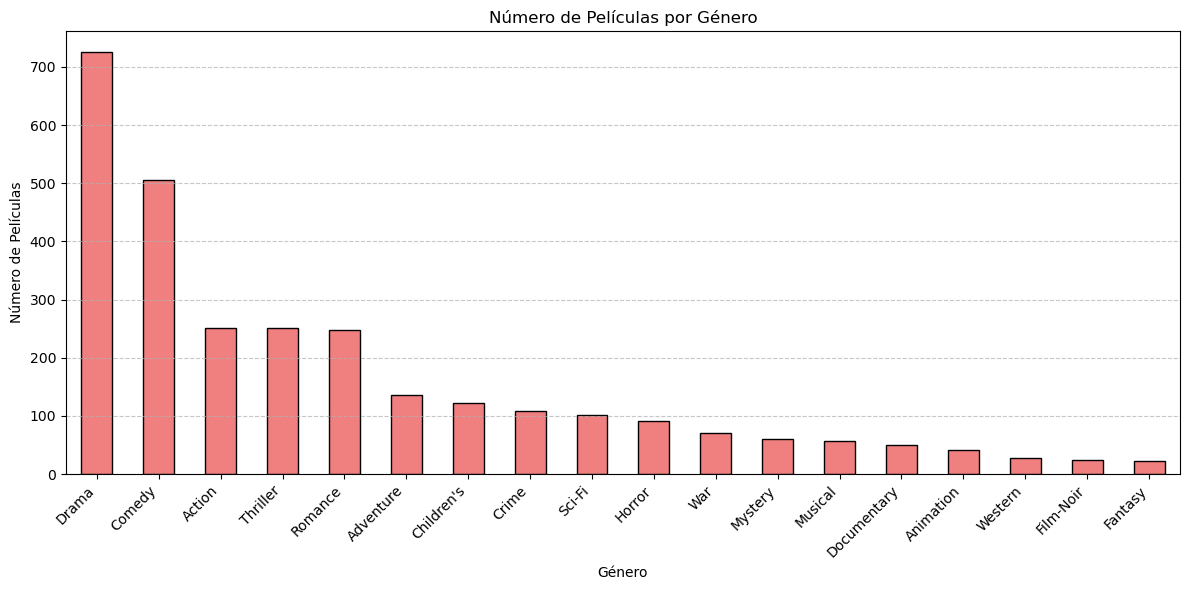

In [90]:
# Información general del dataframe
print("\n### Información General del DataFrame de Películas ###")
print(movies_df.info())

# Vista previa del dataframe
print("\n### Vista Previa del DataFrame de Películas ###")
print(movies_df.head())

# Comprobar datos faltantes
missing_data = movies_df.isnull().sum()
print(f"\n### Datos Faltantes en las Columnas ###\n{missing_data[missing_data > 0]}")

# Estadísticas descriptivas para columnas numéricas y categóricas
print(f"\n### Estadísticas Descriptivas ###\n{movies_df.describe(include='all')}")

# Comprobar tipos de datos de las columnas de géneros
genre_data_types = movies_df.iloc[:, 6:].dtypes
print(f"\n### Tipos de Datos en las Columnas de Géneros ###\n{genre_data_types}")

# Convertir las columnas de género a numérico (si no lo son ya)
movies_df.iloc[:, 6:] = movies_df.iloc[:, 6:].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# Contar el número de películas por género
genre_counts = movies_df.iloc[:, 6:].sum(axis=0).sort_values(ascending=False)
print(f"\n### Conteo de Películas por Género ###\n{genre_counts}")

# Graficar la distribución de géneros
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Número de Películas por Género')
plt.xlabel('Género')
plt.ylabel('Número de Películas')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

El análisis del DataFrame de películas revela un total de 1,682 registros con información completa sobre títulos, fechas de lanzamiento y géneros. La mayoría de las películas pertenecen a los géneros de drama (725) y comedia (505), mientras que géneros como Fantasy y Film-Noir son los menos representados. Los datos no presentan valores faltantes, lo que refuerza la calidad del conjunto. La distribución de géneros destaca una clara tendencia hacia el drama, seguida por comedia, acción y thriller, lo cual refleja patrones específicos de producción cinematográfica durante el período analizado.

In [91]:
# parte 1.1.1.4 carga de profesiones

# Cargar el dataframe de profesiones
professions_df = pd.read_excel('data/u_occupation.xls', header=None, names=['Profession'])

# Vista previa del dataframe
professions_df.head()

Profession
0  administrator
1         artist
2         doctor
3       educator
4       engineer

In [92]:
# parte 1.1.1.5 carga de información de los usuarios

users_df = pd.read_excel('data/u_user_info.xls', header=None) # Cargar el dataframe de usuarios

users_df = users_df[0].str.split('|', expand=True) # Separar la columna en múltiples columnas utilizando el delimitador "|"

users_df.columns = ['User ID', 'Age', 'Gender', 'Occupation', 'Zip Code'] # Nombrar las columnas

# Convertir 'User ID' y 'Age' a enteros
users_df['User ID'] = users_df['User ID'].astype(int)
users_df['Age'] = users_df['Age'].astype(int)

# Vista previa del dataframe
users_df.head()

User ID  Age Gender  Occupation Zip Code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213

In [93]:
# El análisis consiste en determinar las preferencias de géneros de películas según la edad y el género de los usuarios.
# 1. Se cargan y combinan los dataframes de usuarios (users_df), calificaciones (ratings_df) y películas (movies_df) 
#    para crear un dataframe extendido con información demográfica, calificaciones y detalles de las películas vistas por cada usuario.
# 2. Luego, se transforma el dataframe de películas para descomponer los géneros en filas individuales (usando 'melt') 
#    y se filtran solo las filas que indican que una película pertenece a un género específico.
# 3. Finalmente, se agrupan los datos por edad, género de usuario y tipo de género de película para calcular:
#    - El número total de calificacione


# Unir los dataframes para tener una vista completa
merged_df = pd.merge(pd.merge(ratings_df, users_df, on='User ID'), movies_df, on='Movie ID')

# Convertir las columnas de género de movies_df a enteros, por si hay algún problema
for col in movies_df.columns[6:]:
    movies_df[col] = movies_df[col].astype(int)

# Generar un dataframe donde cada fila tenga la información de la película y la preferencia
# 'melt' permite transformar las columnas de géneros en filas
genre_preferences_df = pd.melt(movies_df, id_vars=['Movie ID', 'Title'], value_vars=movies_df.columns[6:],var_name='Genre', value_name='IsGenre')

# Filtrar solo las filas donde IsGenre es 1
genre_preferences_df = genre_preferences_df[genre_preferences_df['IsGenre'] == 1]

# Unir este nuevo dataframe con merged_df
complete_df = pd.merge(merged_df, genre_preferences_df, on='Movie ID')

# Calcular las preferencias por edad y género de usuario
age_gender_genre_prefs = complete_df.groupby(['Age', 'Gender', 'Genre']).agg({
    'Rating': ['count', 'mean']
}).reset_index()

# Nombrar columnas para mayor claridad
age_gender_genre_prefs.columns = ['Age', 'Gender', 'Genre', 'Count', 'Average Rating']

# Mostrar las preferencias calculadas
age_gender_genre_prefs.head()

Age Gender       Genre  Count  Average Rating
0    7      M      Action     14        3.785714
1    7      M   Adventure     11        3.545455
2    7      M   Animation      1        4.000000
3    7      M  Children's      5        3.800000
4    7      M      Comedy     15        3.666667

La información permite analizar las preferencias de los usuarios según edad y género, observando cómo evalúan diferentes géneros de películas. Por ejemplo, para niños de 7 años, se destacan géneros como Action, Comedy, y Adventure en términos de cantidad de calificaciones, lo que indica su popularidad. La columna de calificaciones promedio (Average Rating) revela la calidad percibida de los géneros; aunque géneros como Animation reciben menos calificaciones, son bien valorados (4.0), sugiriendo una alta satisfacción a pesar de su menor consumo.

Al comparar la cantidad de calificaciones y las calificaciones promedio, se pueden identificar tendencias y contrastes entre la popularidad y la calidad percibida. Un género con muchas calificaciones pero un puntaje promedio moderado, como Action (con 14 calificaciones y un promedio de 3.78), podría indicar que, aunque es popular, no siempre cumple con las expectativas de los usuarios. Estos datos son útiles para segmentar audiencias, entender preferencias y diseñar estrategias de marketing o recomendaciones personalizadas.

In [94]:
# parte 1.1.1.6 consolidación de la matriz usuario - película

# Crear la matriz de usuario-película utilizando un pivot
user_movie_matrix = ratings_df.pivot(index='Movie ID', columns='User ID', values='Rating')

# Llenar los valores faltantes con 0 (películas no vistas por usuarios)
user_movie_matrix = user_movie_matrix.fillna(0)

# Vista previa de la matriz de usuario-película
user_movie_matrix.head()


User ID   1    2    3    4    5    6    7    8    9    10   ...  908  910  \
Movie ID                                                    ...             
1         5.0  4.0  0.0  0.0  4.0  4.0  0.0  0.0  0.0  4.0  ...  0.0  0.0   
2         3.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4         3.0  0.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  4.0  ...  0.0  0.0   
5         3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

User ID   911  912  913  914  916  918  919  921  
Movie ID                                          
1         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 916 columns]

### Parte 1.2 Implemetación de NMF

In [95]:
# Establecer el número de componentes latentes (k)
k = 10  # Ajustar este valor según la necesidad del modelo

# Obtener las dimensiones de la matriz V
m, n = user_movie_matrix.shape

# Inicializar W y H con valores aleatorios no negativos
W = np.random.rand(m, k)
H = np.random.rand(k, n)

# Definir el número de iteraciones y el umbral de convergencia
num_iterations = 1000
epsilon = 1e-10

# Iterar para actualizar W y H
for iteration in range(num_iterations):
    # Actualizar H
    W_T = W.T
    numerator_H = np.dot(W_T, user_movie_matrix)
    denominator_H = np.dot(W_T, np.dot(W, H)) + epsilon
    H *= numerator_H / denominator_H

    # Actualizar W
    numerator_W = np.dot(user_movie_matrix, H.T)
    denominator_W = np.dot(W, np.dot(H, H.T)) + epsilon
    W *= numerator_W / denominator_W

# Reconstrucción final de la matriz
R_reconstructed = np.dot(W, H)

# Crear un nuevo DataFrame usando índices y columnas basados en user_movie_matrix
df_reconstructed = pd.DataFrame(R_reconstructed, columns=user_movie_matrix.columns, index=user_movie_matrix.index)

# Imprimir la matriz reconstruida
print("\nMatriz reconstruida:")
print(df_reconstructed.head(5))


Matriz reconstruida:
User ID        1         2         3         4         5         6    \
Movie ID                                                               
1         3.958439  2.089410  0.084866  0.540751  3.859046  2.037921   
2         1.421002  0.019417  0.042764  0.024152  0.526893  0.056692   
3         0.804721  0.263668  0.031095  0.027867  0.793893  0.241008   
4         2.516521  0.071892  0.067805  0.046068  0.840441  1.438644   
5         0.683730  0.095840  0.023943  0.000993  0.636653  0.012783   

User ID        7         8         9         10   ...           908       910  \
Movie ID                                          ...                           
1         1.597391  0.792996  0.366329  1.418989  ...  6.974683e-04  0.015452   
2         2.172920  1.787238  0.007215  0.347141  ...  1.038475e-02  0.033874   
3         1.966239  0.033709  0.028662  0.204168  ...  1.854451e-02  0.005118   
4         3.708281  1.604525  0.061123  1.610687  ...  1.147474e-01 

### 3. ¿Cómo puedo evaluar qué películas le podrían gustar a un usuario nuevo (que no esté en la base de datos) basado en las calificaciones que este da a una serie de películas?

**Respuesta:**

Para evaluar qué películas podrían gustarle a un usuario nuevo basado en las calificaciones que proporciona, se puede usar un enfoque basado en "Filtrado Colaborativo K-Vecinos Más Cercanos" (KNN) o técnicas de factorización matricial adaptadas:

1. **Filtrado Basado en Vecinos**:
   - Se puede identificar a usuarios que ya están en la base de datos y que tienen patrones de calificación similares para las películas que el nuevo usuario ha calificado.
   - Esto se hace calculando la similitud entre el nuevo usuario y los usuarios existentes usando métricas como el **coseno de similitud** o la **correlación de Pearson**.
   - A partir de ahí, se recomiendan películas que los usuarios similares han calificado altamente, pero que el nuevo usuario aún no ha visto.

2. **Factorización Matricial con Cold Start**:
   - El nuevo usuario puede ser incorporado en la matriz de calificaciones con sus valoraciones iniciales. Usando NMF o SVD, se pueden calcular las características latentes de este usuario a partir de las películas que ha calificado.
   - Luego, se reconstruyen sus preferencias para otras películas basándose en las características latentes calculadas, generando una lista de recomendaciones.

3. **Modelos Basados en Contenido**:
   - Otra opción es analizar las características de las películas que el nuevo usuario ha calificado (género, director, actores, etc.).
   - Con esto, se puede identificar películas similares en la base de datos que aún no ha visto y recomendarlas, incluso si no hay usuarios similares en la base de datos.

---

### 4. Análisis sobre cómo incorporar toda la información otorgada.

**Respuesta:**

Para mejorar la calidad de las recomendaciones, se puede incorporar toda la información disponible de la siguiente manera:

1. **Datos Demográficos**:
   - Incorporar datos como **edad, género, ocupación** y **localización** del usuario para construir perfiles más completos. 
   - Por ejemplo, si se sabe que un grupo demográfico específico tiene una preferencia por ciertos géneros, se pueden ajustar las recomendaciones para nuevos usuarios que compartan características demográficas similares.

2. **Información de Películas**:
   - Usar metadatos de las películas, como **género, año de lanzamiento, director, actores, duración**, etc., para hacer recomendaciones basadas en contenido.
   - Por ejemplo, si un usuario muestra preferencia por películas de ciencia ficción dirigidas por ciertos directores, se pueden priorizar películas con características similares.

3. **Datos Históricos de Calificaciones**:
   - Utilizar los datos históricos de calificaciones para detectar patrones de preferencia a lo largo del tiempo. Se puede implementar un sistema de **aprendizaje continuo** que actualice las preferencias de los usuarios a medida que se recopilan más datos.

4. **Enriquecimiento de Datos**:
   - Incorporar datos externos, como **reseñas de críticos**, **puntuaciones en plataformas de cine**, y **tendencias de visualización** para afinar aún más las recomendaciones.

---

### 5. ¿Qué se puede inferir sobre los diferentes usuarios y sus gustos en películas? Se puede encontrar alguna relación entre edad, profesión, sexo y género de películas que les gusta a estos grupos? ¿Cómo se podría obtener esta información?

**Respuesta:**

1. **Inferencias sobre Usuarios y Gustos**:
   - Se pueden observar patrones de preferencia en función de la demografía. Por ejemplo, los jóvenes pueden preferir géneros como la acción o la comedia, mientras que los adultos mayores pueden inclinarse más hacia dramas o documentales.
   - Además, la profesión también puede influir. Por ejemplo, profesionales creativos podrían preferir películas independientes o de autor, mientras que otros podrían preferir blockbusters.

2. **Relaciones entre Demografía y Géneros**:
   - Realizar análisis estadísticos, como **regresiones** o **análisis de clusters**, puede ayudar a identificar grupos de usuarios con preferencias similares.
   - También se pueden crear **tablas de contingencia** que muestren la frecuencia de diferentes géneros preferidos por grupos de edad, sexo y profesión.

3. **Obtención de Información**:
   - Realizar encuestas o cuestionarios a los usuarios para recopilar información demográfica y sus preferencias de películas.
   - Incorporar datos de redes sociales y plataformas de streaming que puedan proporcionar información sobre los hábitos de visualización y preferencias de los usuarios.
   - Usar técnicas de **minería de datos** para analizar patrones en las calificaciones y las interacciones de los usuarios con las películas en la base de datos.

### discusión sobre el problema

Este problema, necesitaba de mucho mas tiempo del que, por varias razones le dedique, es probable que hubiera encontrado la solucion para hacer el sistema de recomendación

## PROBLEMA 2: 

### Parte 1.1 procesamiento de datos

In [96]:
# Parte 1.1.1 carga de datos

# Lista de nombres de pinturas
pinturas = ["Bosch", "Boticelli", "Dali", "Monet", "Picaso", "VanGogh", "Velazquez", "Vermeer"]

# Diccionario para almacenar las imágenes RGB
imagenes_rgb = {}

# Cargar todas las imágenes y convertirlas a RGB
for pintura in pinturas:
    imagen = cv2.imread(f"Paintings/{pintura}.jpg")
    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
    imagenes_rgb[pintura] = imagen_rgb


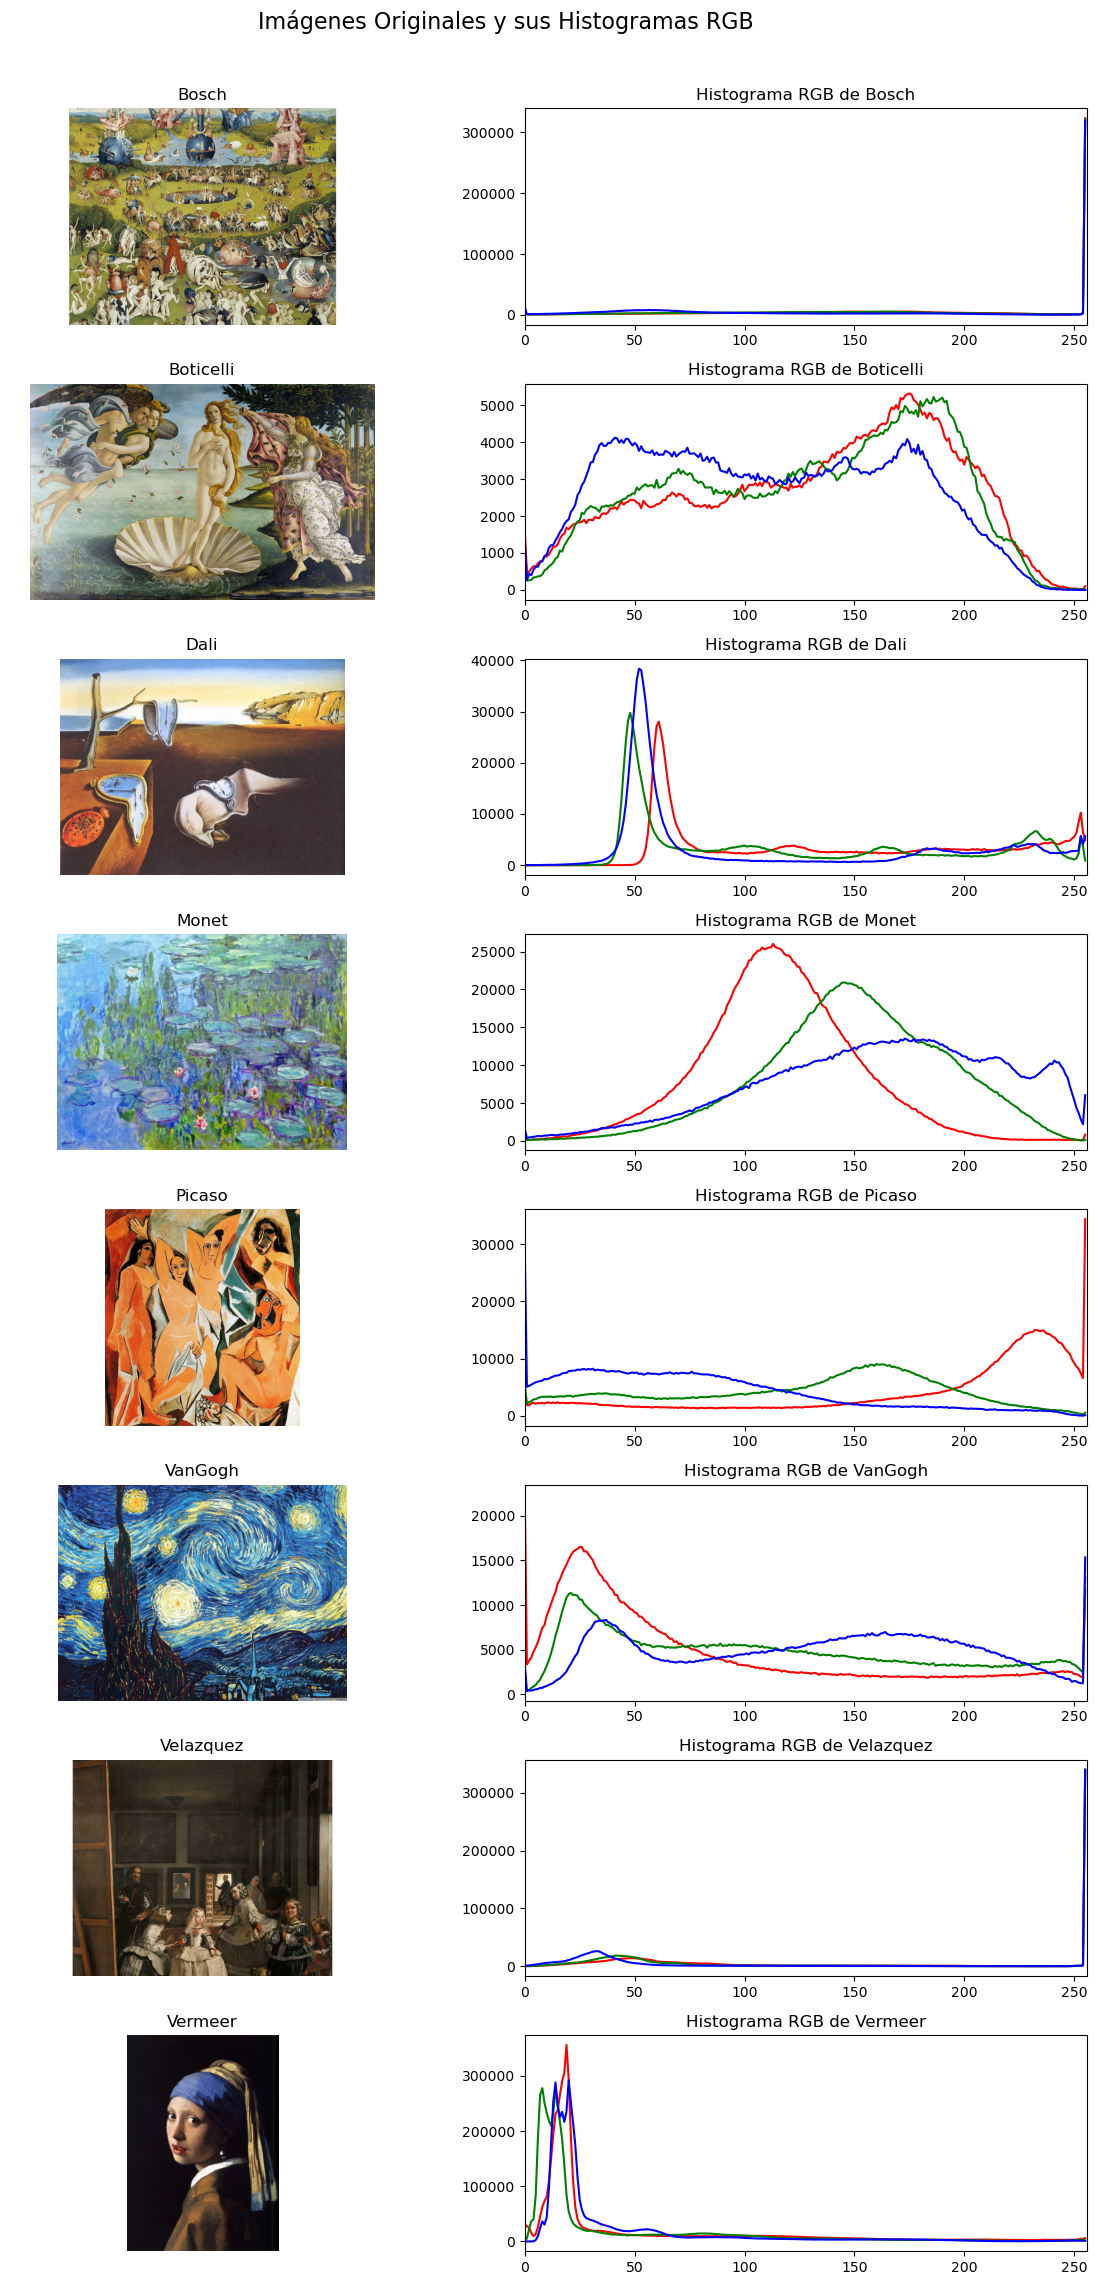

In [97]:
# Parte 1.1.2 visualizacion de todas las imagenes

# Función para mostrar una matriz 8x2 de las imágenes originales y sus histogramas
def mostrar_matriz_imagenes(imagenes):
    fig, axs = plt.subplots(8, 2, figsize=(12, 24))
    fig.suptitle('Imágenes Originales y sus Histogramas RGB', fontsize=16)

    for i, (nombre, imagen_rgb) in enumerate(imagenes.items()):
        # Mostrar la imagen original
        axs[i, 0].imshow(imagen_rgb)
        axs[i, 0].set_title(nombre)
        axs[i, 0].axis('off')
        
        # Mostrar el histograma RGB
        colores = ('r', 'g', 'b')
        for j, color in enumerate(colores):
            histograma = cv2.calcHist([imagen_rgb], [j], None, [256], [0, 256])
            axs[i, 1].plot(histograma, color=color)
        axs[i, 1].set_title(f'Histograma RGB de {nombre}')
        axs[i, 1].set_xlim([0, 256])

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Llamar a la función para mostrar la matriz de imágenes y sus histogramas
mostrar_matriz_imagenes(imagenes_rgb)

### descripcion de imagenes y sus histogramas

## Descripción de Histogramas

| **Nombre de la Imagen**        | **Descripción del Histograma**                               | **Notas Adicionales**                          |
|--------------------------------|-------------------------------------------------------------|------------------------------------------------|
| Bosch     | Histograma que muestra una tendencia muy clara al azul |  |
| Boticcelli    | Histograma que muestra una distribución pareja de colores |  |
| Dali   | Histograma que muestra los colores con bastante sesgo hacia la derecha|  |
| Monet   | Histograma que muestra rojo, con una distribución bastente parecida a la normal |  |
| Picasso   | Histograma que muestra una marcada tendencia del rojo |  |
| Van Gogh   | Histograma que muestra una predominancia del rojo |  |
| Velazquez   | Histograma que muestra unclarisimo dominio del azul |  |
| Vermeer   | Histograma que muestra una distribución pareja de los tres colores |  |



### Parte 1.2 aplicacion de cuantizacion de imagenes

In [98]:
# Función para cuantizar la imagen usando K-means
def cuantizar_imagen(imagen_rgb, k):
    # Convertir la imagen a un arreglo 2D de píxeles (número de píxeles, 3)
    pixeles = imagen_rgb.reshape((-1, 3))
    pixeles = np.float32(pixeles)  # Convertir a float32 para K-means

    # Criterios de terminación de K-means (10 iteraciones o una precisión de 1.0)
    criterios = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    # Aplicar K-means
    _, etiquetas, centros = cv2.kmeans(pixeles, k, None, criterios, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convertir los centros a enteros (valores de 0 a 255)
    centros = np.uint8(centros)

    # Reemplazar cada píxel con el color de su centro
    imagen_cuantizada = centros[etiquetas.flatten()]
    imagen_cuantizada = imagen_cuantizada.reshape(imagen_rgb.shape)

    return imagen_cuantizada

In [99]:
# Función para sobreexponer los píxeles rojos
def sobreexponer_rojo(imagen_rgb, factor_peso=2):
    """
    Aumenta la intensidad de los píxeles rojos en una imagen duplicando sus ocurrencias.
    :param imagen_rgb: Imagen en formato RGB
    :param factor_peso: Factor de ponderación para los píxeles rojos
    :return: Imagen con píxeles rojos sobreexpuestos.
    """
    # Crear una copia de la imagen y convertir a float para procesar los píxeles
    imagen_modificada = imagen_rgb.copy()
    alto, ancho, canales = imagen_modificada.shape
    pixeles = imagen_modificada.reshape((-1, 3))

    # Definir un umbral para considerar un píxel como "rojo"
    umbral_rojo = 150

    # Filtrar los píxeles rojos según los criterios
    pixeles_rojos = pixeles[(pixeles[:, 0] > umbral_rojo) & (pixeles[:, 1] < umbral_rojo / 2) & (pixeles[:, 2] < umbral_rojo / 2)]

    # Duplicar los píxeles rojos según el factor de ponderación
    pixeles_ponderados = np.vstack([pixeles] + [pixeles_rojos] * factor_peso)

    # Reorganizar los píxeles para que coincidan con la forma original de la imagen
    cantidad_pixeles_original = alto * ancho
    pixeles_recortados = pixeles_ponderados[:cantidad_pixeles_original]
    imagen_modificada = pixeles_recortados.reshape((alto, ancho, canales))

    return imagen_modificada


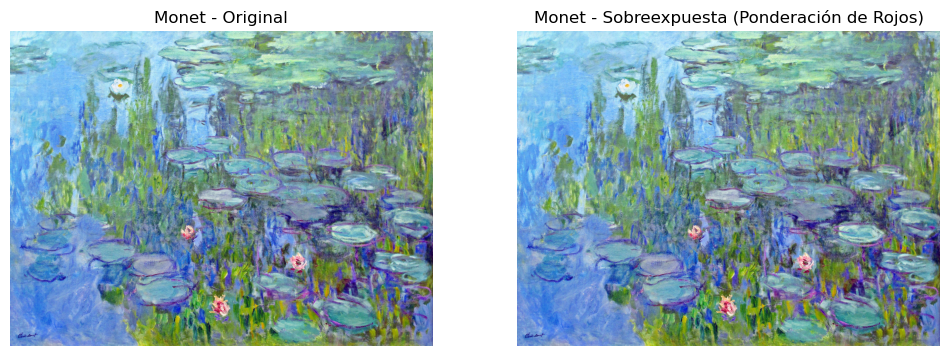

In [100]:
def sobreexponer_rojo(imagen_rgb, factor_peso=2, nombre=''):
    """
    Aumenta la intensidad de los píxeles rojos en una imagen duplicando sus ocurrencias.
    :param imagen_rgb: Imagen en formato RGB
    :param factor_peso: Factor de ponderación para los píxeles rojos
    :param nombre: Nombre de la pintura para aplicar este ajuste solo a Monet
    :return: Imagen con píxeles rojos sobreexpuestos si es Monet; si no, devuelve la imagen original.
    """
    # Si la pintura no es Monet, devolver la imagen original
    if nombre != "Monet":
        return imagen_rgb

    # Crear una copia de la imagen y convertir a float para procesar los píxeles
    imagen_modificada = imagen_rgb.copy()
    alto, ancho, canales = imagen_modificada.shape
    pixeles = imagen_modificada.reshape((-1, 3))

    # Definir un umbral para considerar un píxel como "rojo"
    umbral_rojo = 150

    # Filtrar los píxeles rojos según los criterios
    pixeles_rojos = pixeles[(pixeles[:, 0] > umbral_rojo) & (pixeles[:, 1] < umbral_rojo / 2) & (pixeles[:, 2] < umbral_rojo / 2)]

    # Duplicar los píxeles rojos según el factor de ponderación
    pixeles_ponderados = np.vstack([pixeles] + [pixeles_rojos] * factor_peso)

    # Reorganizar los píxeles para que coincidan con la forma original de la imagen
    # Esto es importante para que la imagen cuantizada conserve su tamaño original.
    # Debemos asegurarnos de que la cantidad total de píxeles no cambie.
    cantidad_pixeles_original = alto * ancho
    pixeles_recortados = pixeles_ponderados[:cantidad_pixeles_original]
    imagen_modificada = pixeles_recortados.reshape((alto, ancho, canales))

    return imagen_modificada

# Aplicar la sobreexposición a los píxeles rojos de la pintura de Monet
imagen_monet = imagenes_rgb['Monet']
imagen_monet_sobreexpuesta = sobreexponer_rojo(imagen_monet, factor_peso=3, nombre='Monet')

# Mostrar la imagen original y la sobreexpuesta para comparación
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(imagen_monet)
plt.title('Monet - Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imagen_monet_sobreexpuesta)
plt.title('Monet - Sobreexpuesta (Ponderación de Rojos)')
plt.axis('off')

plt.show()

### Descripción y Análisis del Código

El código tiene como objetivo aumentar la intensidad de los píxeles rojos en una imagen de una pintura de Monet. Aquí se detalla el funcionamiento y los motivos detrás de cada parte del código:

#### 1. **Definición de la Función**
- La función `sobreexponer_rojo` toma tres parámetros:
  - `imagen_rgb`: La imagen de entrada en formato RGB.
  - `factor_peso`: Un valor que determina cuánto se deben duplicar los píxeles rojos (por defecto, se establece en 2).
  - `nombre`: El nombre de la pintura para aplicar el ajuste solamente a las obras de Monet.

#### 2. **Control de Aplicación del Ajuste**
- La función comprueba si el nombre de la pintura es "Monet". Si no lo es, devuelve la imagen original sin cambios. Esto asegura que la sobreexposición solo se aplique a las pinturas de Monet.

#### 3. **Preparación de la Imagen**
- Se crea una copia de la imagen para evitar modificar la imagen original.
- La imagen se convierte en un formato que permite acceder y manipular los píxeles de forma más sencilla, descomponiéndola en un arreglo unidimensional de píxeles.

#### 4. **Filtrado de Píxeles Rojos**
- Se define un umbral para identificar los píxeles que son predominantemente rojos.
- Se utilizan condiciones para filtrar los píxeles que tienen un alto valor en el canal rojo y bajos valores en los canales verde y azul.

#### 5. **Duplicación de Píxeles Rojos**
- Se duplican los píxeles que han sido identificados como rojos según el `factor_peso`.
- Esto crea un nuevo arreglo que contiene más ocurrencias de los píxeles rojos, intensificando su presencia en la imagen.

#### 6. **Reorganización de Píxeles**
- La cantidad total de píxeles en la imagen modificada se recorta para igualar la cantidad de píxeles en la imagen original. Esto es crucial para mantener la estructura y el tamaño de la imagen.

#### 7. **Visualización**
- Finalmente, se utiliza `matplotlib` para mostrar la imagen original de Monet y la imagen sobreexpuesta lado a lado, facilitando una comparaci


In [101]:
# Función para calcular el MSE entre la imagen original y la cuantizada
def calcular_mse(imagen_original, imagen_cuantizada):
    # Convertir las imágenes a un arreglo 2D para calcular el MSE
    original = imagen_original.reshape((-1, 3))
    cuantizada = imagen_cuantizada.reshape((-1, 3))
    mse = mean_squared_error(original, cuantizada)
    return mse

In [102]:
# Función para encontrar el mejor valor de K para cada imagen
def encontrar_mejor_k(imagen_rgb, nombre):
    mse_minimo = float('inf')
    mejor_k = 0
    mejor_imagen = None

    # Iterar sobre posibles valores de K
    for k in range(1, 16):
        # Cuantizar la imagen con el valor actual de K
        imagen_cuantizada = cuantizar_imagen(imagen_rgb, k)
        # Calcular el MSE entre la imagen original y la cuantizada
        mse = calcular_mse(imagen_rgb, imagen_cuantizada)

        # Si el MSE es menor que el mínimo registrado, actualizar mejor K y mejor imagen
        if mse < mse_minimo:
            mse_minimo = mse
            mejor_k = k
            mejor_imagen = imagen_cuantizada

    # Mostrar la imagen cuantizada con el mejor K
    plt.figure(figsize=(8, 8))
    plt.imshow(mejor_imagen)
    plt.title(f'{nombre} - Mejor Cuantizado con K={mejor_k}')
    plt.axis('off')
    plt.show()

    return mejor_k, mejor_imagen


<Figure size 1600x800 with 0 Axes>

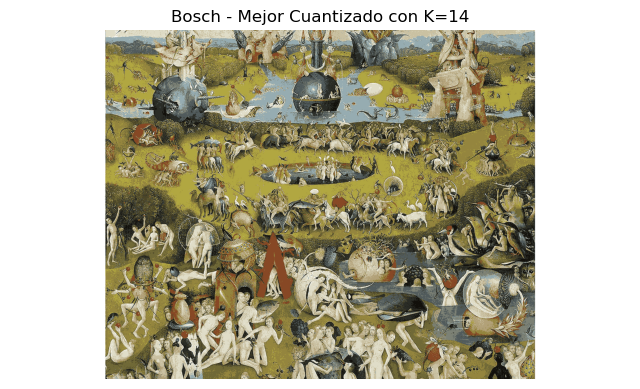

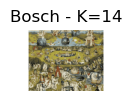

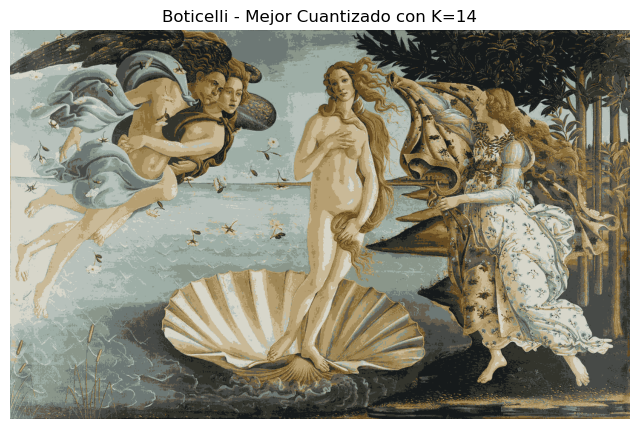

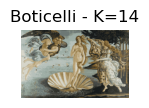

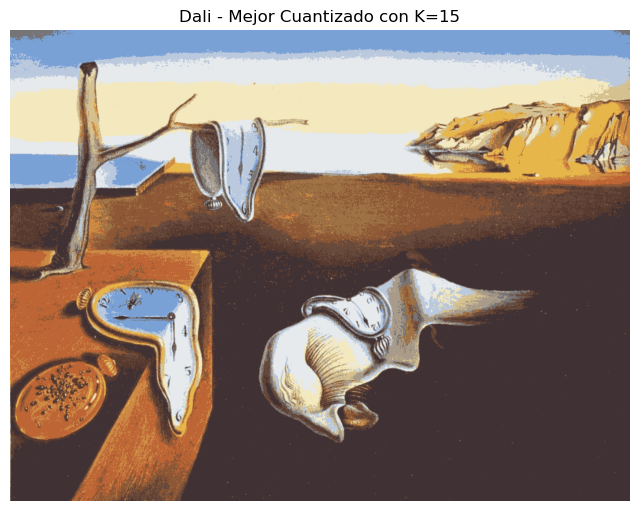

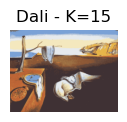

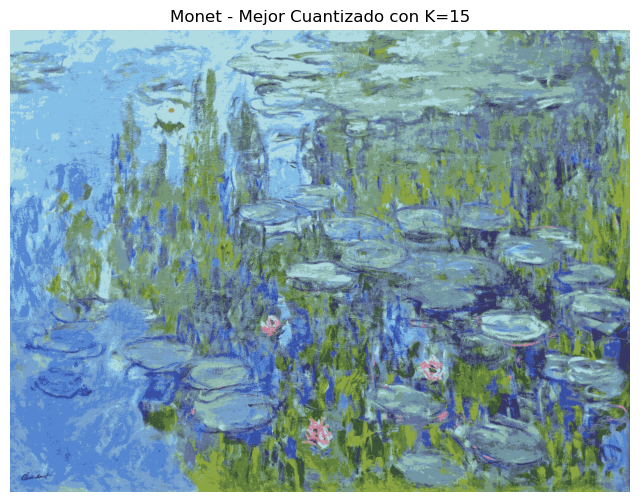

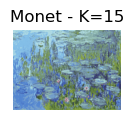

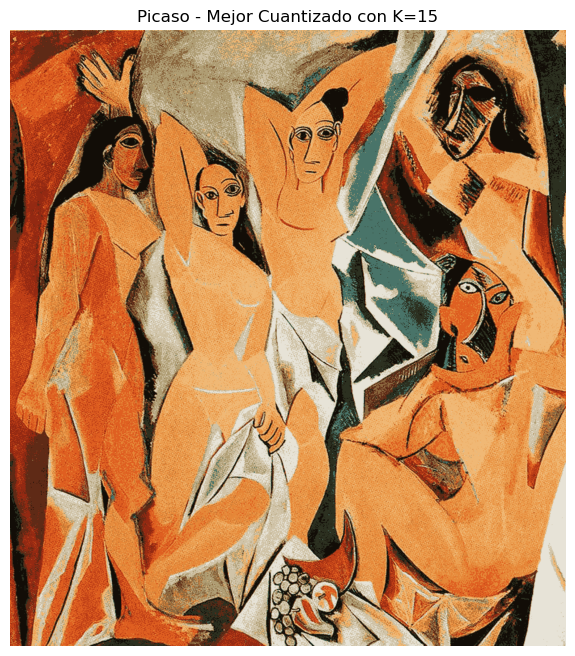

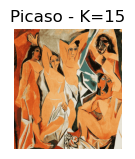

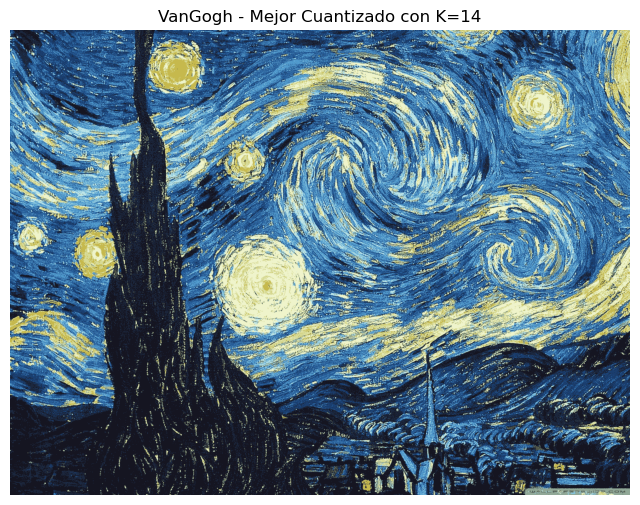

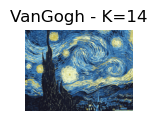

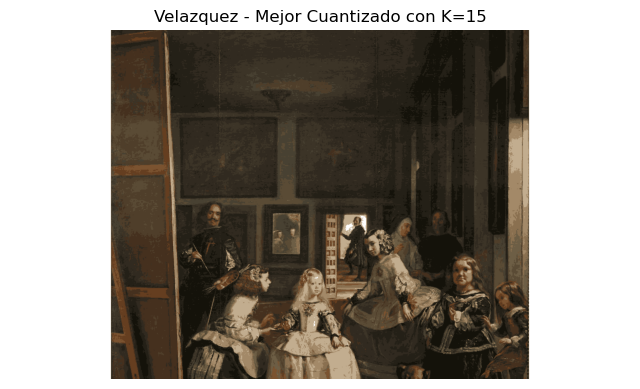

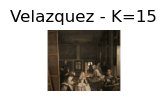

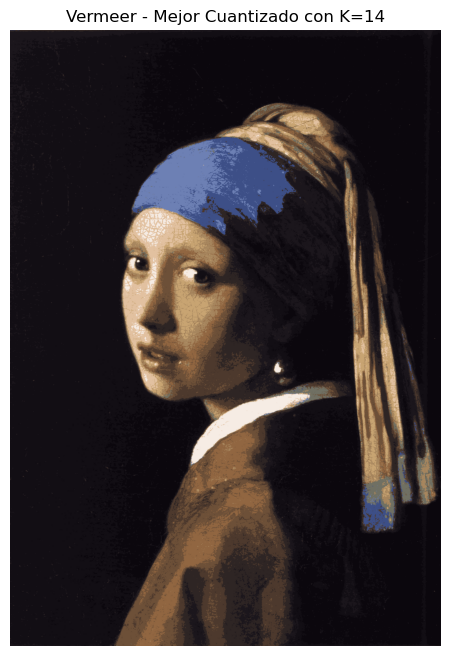

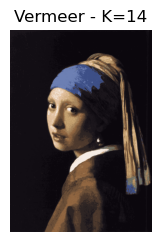

In [103]:


# Función para mostrar solo las imágenes cuantizadas en una cuadrícula 2x4
def mostrar_imagenes_cuantizadas(imagenes):
    plt.figure(figsize=(16, 8))
    plt.suptitle('Imágenes Cuantizadas con la Mejor Paleta de Colores', fontsize=16)

    # Iterar sobre las imágenes y sus nombres
    for i, (nombre, imagen_rgb) in enumerate(imagenes.items()):
        # Encontrar el mejor valor de K y la imagen cuantizada
        mejor_k, imagen_cuantizada = encontrar_mejor_k(imagen_rgb, nombre)
        
        # Calcular las posiciones para la cuadrícula 2x4
        fila = i // 4
        columna = i % 4
        posicion = fila * 4 + columna + 1  # Calcular la posición en la cuadrícula 2x4
        
        # Crear cada subplot individualmente
        plt.subplot(2, 4, posicion)
        plt.imshow(imagen_cuantizada)
        plt.title(f'{nombre} - K={mejor_k}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Llamar a la función para mostrar solo las imágenes cuantizadas
mostrar_imagenes_cuantizadas(imagenes_rgb)



1. ¿Esta a gusto con la cuantización realizada?
R = creo que la cuantizacion realizada es buena, reproduce las imagenes fielmente
2. ¿Cómo puede mejorar los resultados?
R = los resultados podrían mejorarse con una paleta de colores mas grande y, para el caso de monet, sobre exponer aun mas los rojos.
3. Describa brevemente que han hecho los algoritmos de clustering y sus diferencias. Puede usar figuras, gráficas, etc para complementar esta respuesta.
los algoritmos de clustering 
R = Los algoritmos de clustering, como K-means, agrupan los píxeles de la imagen según sus características de color, reduciendo así la cantidad de colores en la imagen. K-means segmenta los colores en k grupos predefinidos. Esta diferencia permite que K-means sea más controlado.
1. ¿Qué problemas tuvo a la hora de realizar esta parte del proyecto?
R = uno de los problemas mas grandes a la hora de realizar este proyecto fue que la idea de sobreexponer los rojos en monet, tiene un buen